In [5]:
%pylab nbagg

from tvb.simulator.lab import *

import numpy as np
import time as tm 

Populating the interactive namespace from numpy and matplotlib


<h1><font size="6" face="arial" color="#000000">Reduction 2-dimentional Epileptor model</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">The <b>Epileptor 2D</b> model is the reduction of the 5 dimensions Epileptor model to only 2 dimensions, by applying averaging methods (see <b>Proix et al., 2014</b>). Then, the Epileptor equations become :</font></div></p>

\begin{eqnarray}
    \dot{x}_{1,i} &=& - x_{1,i}^{3} - 2x_{1,i}^{2} + 1 + I_{ext_{1}}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (4(x_{1,i} - x_{0, i}) - z_{i} - K{s}\sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i})))
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">where $\tau_{0}=2857$, $I_{ext_{1}}=3.1$, and and the degree of epileptogenicity is represented through the value $x_{0}$. $C_{ij}$ are the entries of the anatomical structural connectivity matrix reweigthed by the global coupling parameter $K_{s}$.</font></div></p>

<h1><font size="6" face="arial" color="black"> 1. Exploring the Epileptor 2D model</font></h1>
<br>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Before launching any simulations, we will have a look at the <b>phase space</b> of the model in order to better understand its dynamics. We will use the phase plane interactive tool.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">We plot the two nullclines that are defined as zero flux in either the $x_{1}$ or $z$ direction: the linear nullcline in green and the cubic nullcline in red. The intersections of the nullclines identify the fixed points of the system. The <b>interictal state</b> and the <b>ictal state</b> correspond to the <b>left</b> and the <b>right</b> branches of the cubic nullcline, respectively.</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman">Have a look to the phase space for the <b>2D system</b> (Fig. 8C in Proix et al. 2014):</font></div></p>

<IPython.core.display.Javascript object>


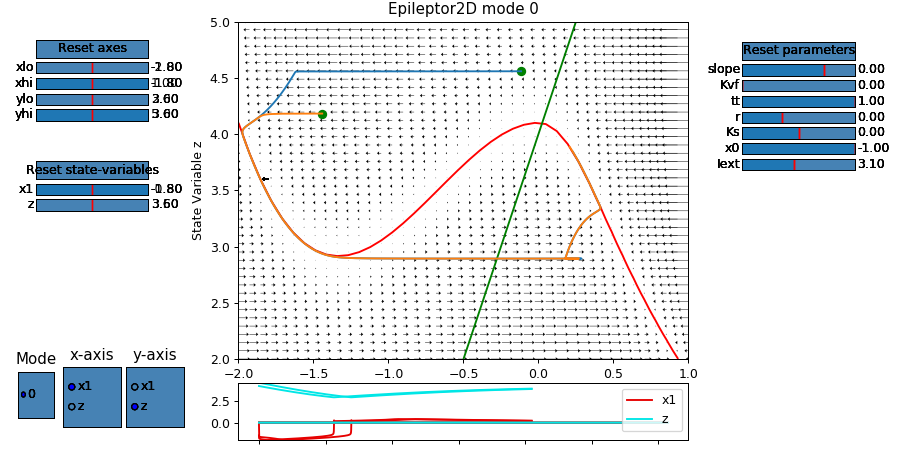

//anaconda/envs/tvb_library_git/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The set_color_cycle attribute was deprecated in version 1.5. Use set_prop_cycle instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
//anaconda/envs/tvb_library_git/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [2]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# Create an Epileptor model instance.
epi = models.epileptor.Epileptor2D(x0=numpy.array([-1]))

# Initialise a stochastic Integrator scheme.
dt = 0.5                                           #integration steps [ms]
heundetint = integrators.HeunDeterministic(dt=dt)
#heunstochint = integrators.HeunStochastic(dt=dt)
#heunstochint.noise.nsig = 0.01                      #standard deviation of the noise 

# Open the phase plane tool with the Epileptor model and (stochastic) Integrator.
ppi_fig = PhasePlaneInteractive(model=epi, integrator=heundetint)
ppi_fig.show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">According to the value of the parameter $\pmb{x_{0}}$, the linear nullcline (green curve) moves left and right, changing the stability of the fixed point. Two typical trajectories are possible:

<ul>
    <li>For $\pmb{x_{0} < -2.05}$, the trajectory is attracted to the <b>stable fixed point</b> in the interictal state on the left cubic nullcline and the Epileptor is said <b>not epileptogenic</b>, meaning not triggering epileptic seizure without external input. </li><br>
    <li>For $\pmb{x_{0} > -2.05}$, the stable point disappears through a Hopf bifurcation, and there is only <b>one unstable fixed point</b> left. The Epileptor enters an <b>oscillatory regime</b> and the Epileptor is said to be <b>epileptogenic</b>, triggering seizures autonomously.</li>
</ul>
</font></div></p>

<h1><font size="6" face="arial" color="black">2. Comparison with complete 5D Epileptor</font></h1>


<p><div style="text-align: justify"><font size="4.5" face="time roman">In order to compare the results obtained from the complete and reduced system, we will model a patient with a temporal lobe epilepsy (TLE).

<br>
To this end, we define a spatial map of epileptogenicity where each network's node $i$ is characterized by an excitability value  $x_{0,i}$, which quantifies its ability to trigger a seizure. 
We set:
<ul>
    <li>the right limbic areas (right hippocampus (rHC, region 47), parahippocampus (rPHC, region 62) and amygdala (rAMYG, region 40)) as <b>Epileptic Zone (EZ)</b> with an epileptogenicity parameter value equal to <b>- 1.6</b>, </li>
    <li>and two lesser epileptogenic regions: the inferior temporal cortex (rTCI, region 69) and the ventral temporal cortex (rTCV, region 72) as <b>Propagation Zone (PZ)</b>, with an epileptogenicity parameter value equal to <b>- 1.8</b>,</li>
    <li>and all the other regions (or <b>Non-Epileptogenic Zone, NEZ</b>) are set to -2.4.</li>
</ul>
</font></div></p> 

In [6]:
# Initialise a Connectivity.
con = connectivity.Connectivity.from_file()
N = con.weights.shape[0]
con.weights - con.weights * np.eye(N, N)
con.weights = con.weights / np.abs(con.weights.max())
con.tract_lengths = np.zeros((con.tract_lengths.shape))             # no time-delays 
con.configure()

WARNING  File 'hemispheres' not found in ZIP.


In [12]:
# Initialise the complete model.
Epileptor5D = models.epileptor.Epileptor(Ks=numpy.array([1]), r=numpy.array([0.00015]))
Epileptor5D.x0 = np.ones((76))*-2.4                #NEZ
Epileptor5D.x0[[62, 47, 40]] = np.ones((3))*-1.6   #EZ
Epileptor5D.x0[[69, 72]] = np.ones((2))*-1.8       #PZ

#Initial conditions.
Epileptor5D.state_variable_range["x1"] = numpy.array([-1.8, -1.8])
Epileptor5D.state_variable_range["y1"] = numpy.array([-15, -15])
Epileptor5D.state_variable_range["x2"] = numpy.array([-1, -1])
Epileptor5D.state_variable_range["y2"] = numpy.array([0.01, 0.01])
Epileptor5D.state_variable_range["z"] = numpy.array([3.6, 3.6])

Epileptor5D.variables_of_interest = ['x2 - x1', 'x1', 'z']

In [13]:
# Initialise Simulator.
sim = simulator.Simulator(model=Epileptor5D, 
                          connectivity=con,
                          coupling=coupling.Difference(a=numpy.array([-0.2])), 
                          integrator=integrators.HeunDeterministic(dt=0.05), 
                          monitors=(monitors.TemporalAverage(period=1.),))

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 60d8fcaf-a834-4a6d-94cb-9a63d6f88449
coupling,Difference gid: 051f193b-ddd0-48cd-b3e4-9e6340d6b357
gid,UUID('549c01ca-c1fe-4737-a569-d77c619ff828')
initial_conditions,None
integrator,HeunDeterministic gid: 8274ca5d-681f-4619-bcd9-f54cec325961
model,Epileptor gid: 934fc6b7-0b87-4457-94cf-8b66ee74c500
monitors,"(,)"
simulation_length,1000.0


In [14]:
print("Starting simulation...")
tic = tm.time()
(t, y), = sim.run(simulation_length=10000)
print("Finished simulation.")
print('execute for' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for84.7481880188


In [15]:
# Initialise the reduced model.
Epileptor2D = models.epileptor.Epileptor2D(Ks=numpy.array([1]), r=numpy.array([0.00015]))
Epileptor2D.x0 = np.ones((76))*-2.4               #NEZ
Epileptor2D.x0[[62, 47, 40]] = np.ones((3))*-1.6  #EZ
Epileptor2D.x0[[69, 72]] = np.ones((2))*-1.8      #PZ

#Initial conditions.
Epileptor2D.state_variable_range["x1"] = numpy.array([-1.8, -1.8])
Epileptor2D.state_variable_range["z"] = numpy.array([3.6, 3.6])

In [16]:
# Initialise Simulator.
sim = simulator.Simulator(model=Epileptor2D, 
                          connectivity=con,
                          coupling=coupling.Difference(a=numpy.array([-0.2])), 
                          integrator=integrators.HeunDeterministic(dt=0.05), 
                          monitors=(monitors.TemporalAverage(period=1.),))

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: 60d8fcaf-a834-4a6d-94cb-9a63d6f88449
coupling,Difference gid: f8f3f6fd-4370-46cc-9871-196ddc99eda8
gid,UUID('4faa1759-9611-4d7e-9453-1a552384e8e3')
initial_conditions,None
integrator,HeunDeterministic gid: 50bcbc52-5d73-468f-8c02-c04ce95b9220
model,Epileptor2D gid: c4476194-d997-4e3d-a8a9-7cdae53da413
monitors,"(,)"
simulation_length,1000.0


In [17]:
print("Starting simulation...")
tic = tm.time()
(s, z), = sim.run(simulation_length=10000)
print("Finished simulation.")
print('execute for' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for74.8618891239


In [18]:
# Normalize the time series to have nice plots
y /= (np.max(y, 0) - np.min(y, 0))
y -= np.mean(y, 0)
z /= (np.max(z, 0) - np.min(z, 0))
z -= np.mean(z, 0)

<IPython.core.display.Javascript object>


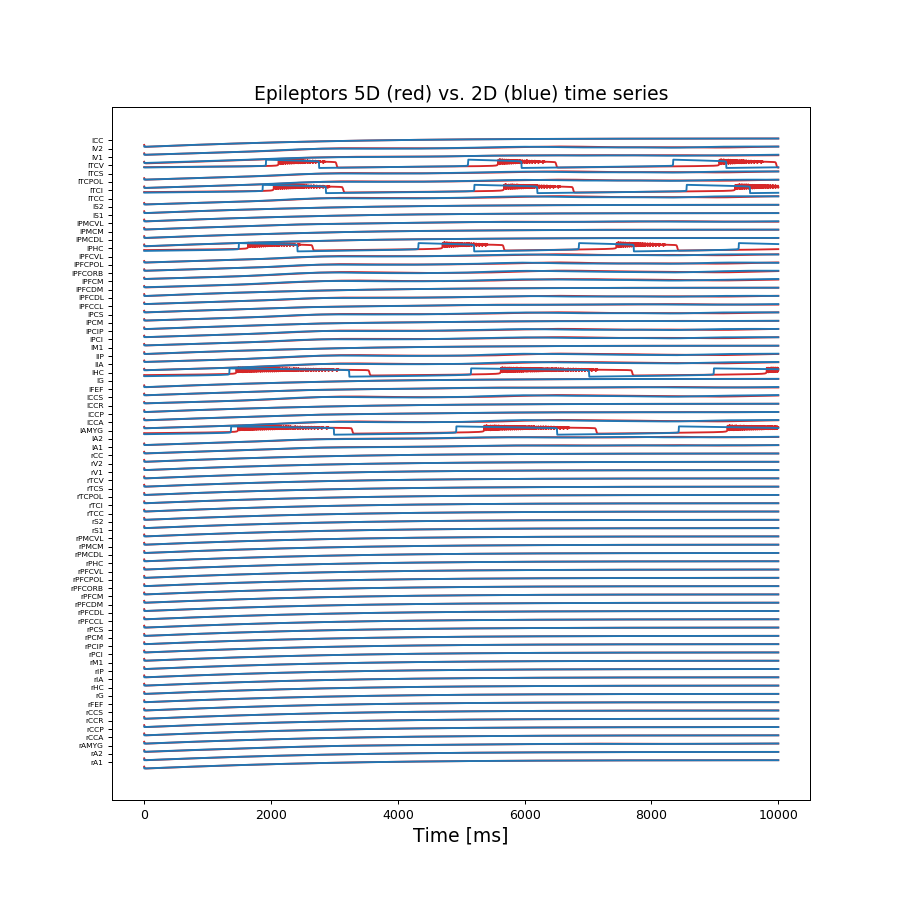

In [19]:
# Plot time series
figure(figsize=(10,10))
plot(t[:], y[:, 1, :, 0] + np.r_[:76], 'C3')
plot(s[:], z[:, 0, :, 0] + np.r_[:76], 'C0')
title("Epileptors 5D (red) vs. 2D (blue) time series", fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(sim.connectivity.region_labels)), sim.connectivity.region_labels, fontsize=6)
show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">Both systems show <b>good correspondance</b> with slight differences in the intrinsic frequencies.</font></div></p>

<h1><font size="6" face="arial" color="black">3. Modification of the slow permittivity variable $z$ dynamics</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">The duration of the ictal and interictal state is approximately the same in the Epileptor, which is not the case in clinical situations, where the <b>interictal period</b> is typically <b>longer</b>. To this end, we use a <b>slight modification</b> of the Epileptor equations and replace the linear influence of $x_{1}$ on the slow permittivity variable $z$ by the <b>nonlinear function</b> $\pmb{h}$ causing a symmetry breaking between ictal and interictal period with an increase of the latter. The Epileptor equations with the here used modification read then as follows:</font></div></p>

\begin{eqnarray}
    \dot{x}_{1,i} &=& - x_{1,i}^{3} - 2x_{1,i}^{2} + 1 + I_{ext_{1}}\\
    \dot{z}_{i} &=& \dfrac{1}{\tau_{0}} \ (h(x_{1,i}) - z_{i} - K{s}\sum_{j=1}^{N}C_{ij}(x_{1,j} - x_{1,i})))
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">where</font></div></p>

\begin{eqnarray}
    h(x_{1,i}) = x_{0,i} + 3. \ / \left(1 + \exp\left(\dfrac{-x_{1,i} - 0.5}{0.1}\right)\right)
\end{eqnarray}

<p><div style="text-align: justify"><font size="4.5" face="time roman">First, we have a look to the phase space of the <b>2D system</b> for the <b>modified Epileptor</b> equations (see Fig. 8B in Proix et al., 2014).</font></div></p>

<IPython.core.display.Javascript object>


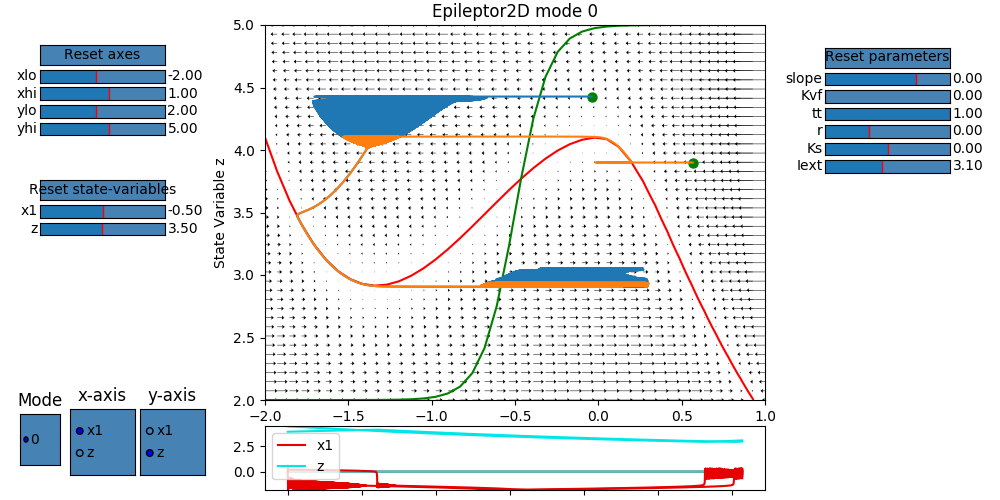

In [8]:
from tvb.simulator.plot.phase_plane_interactive import PhasePlaneInteractive

# Create an Epileptor model instance.
epim = models.epileptor.Epileptor2D(x0=numpy.array([2]), modification=numpy.array([True]))
# Initialise a stochastic Integrator scheme.
dt = 0.75                                           #integration steps [ms]
heundetint = integrators.HeunDeterministic(dt=dt)
#heunstochint = integrators.HeunStochastic(dt=dt)
#heunstochint.noise.nsig = 0.01                      #standard deviation of the noise 

# Open the phase plane tool with the Epileptor model and (stochastic) Integrator.
ppi_fig = PhasePlaneInteractive(model=epim, integrator=heundetint, exclude_sliders=["x0"])
ppi_fig.show()

<p><div style="text-align: justify"><font size="4.5" face="time roman">According to the value of the parameter $\pmb{x_{0}}$, the sigmoid nullcline (green curve) moves up and down, changing the number and stability of the fixed points. Two typical trajectories are possible:

<ul>
    <li>For $\pmb{x_{0} > 2.91}$, the trajectory is attracted to the <b>stable fixed point</b> in the interictal state on the left cubic nullcline and the Epileptor is said <b>not epileptogenic</b>, meaning not triggering epileptic seizure without external input. </li><br>
    <li>For $\pmb{x_{0} < 2.91}$, the two left most fixed points disappear through a SNIC bifurcation, and there is only <b>one unstable fixed point</b> left. The Epileptor enters an <b>oscillatory regime</b> and the Epileptor is said to be <b>epileptogenic</b>, triggering seizures autonomously.</li>
</ul>
</font></div></p>

In [8]:
# Initialise the Model.
Epileptormod = models.epileptor.Epileptor2D(Ks=numpy.array([1.]), r=numpy.array([0.00025]), modification=numpy.array([True]))
Epileptormod.x0 = np.ones((76)) * 3.5
Epileptormod.x0[[62, 47, 40]] = np.ones((3)) * 2.
Epileptormod.x0[[69, 72]] = np.ones((2)) * 2.3

Epileptormod.state_variable_range["x1"] = numpy.array([-1.8, -1.8])
Epileptormod.state_variable_range["z"] = numpy.array([3.6, 3.6])

In [9]:
sim = simulator.Simulator(model=Epileptormod, 
                          connectivity=con,
                          coupling=coupling.Difference(a=numpy.array([-0.2])), 
                          integrator=integrators.HeunDeterministic(dt=0.05), 
                          monitors=(monitors.TemporalAverage(period=1.),))

sim.configure()

,value
Type,Simulator
conduction_speed,3.0
connectivity,Connectivity gid: f7a6a80f-c159-4957-8eda-de105046955a
coupling,Difference gid: 9b57c208-ccb2-4836-8043-10366cb4f50b
gid,UUID('7583170b-d5ce-4ca0-afae-2c22ea5c3e01')
initial_conditions,None
integrator,HeunDeterministic gid: 1f60cbd7-890e-4698-abc0-14ad93058763
model,Epileptor2D gid: 86fceab6-a093-453c-a5b3-b65d499dc58e
monitors,"(,)"
simulation_length,1000.0


In [10]:
print("Starting simulation...")
tic = tm.time()
(s_, z_),  = sim.run(simulation_length=10000)
print("Finished simulation.")
print('execute for' + str(tm.time()-tic))

Starting simulation...
Finished simulation.
execute for70.0890700817


In [11]:
# Normalize the time series to have nice plots
z_ /= (np.max(z_,0) - np.min(z_,0 ))
z_ -= np.mean(z_, 0)

<IPython.core.display.Javascript object>


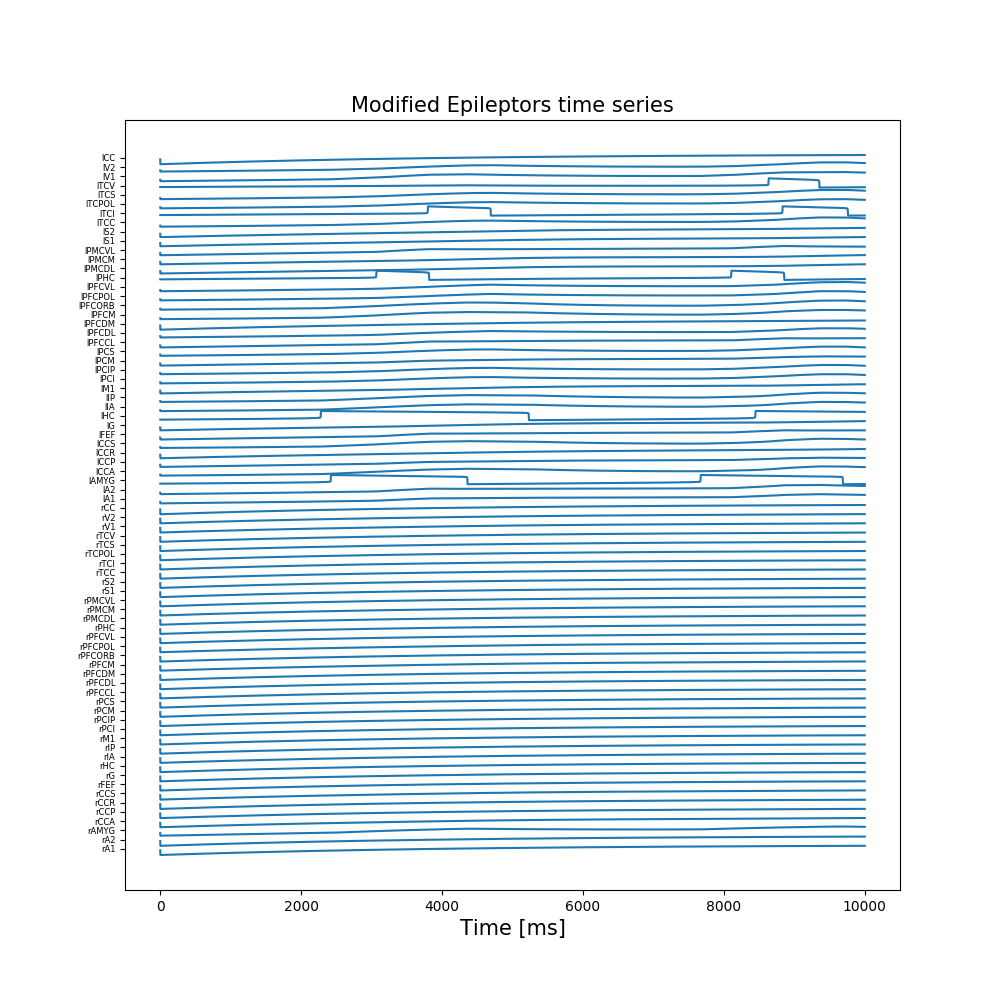

In [12]:
# Plot time series
figure(figsize=(10,10))
#plot(s[:], z[:, 0, :, 0] + np.r_[:76], 'C4')
plot(s_[:], z_[:, 0, :, 0] + np.r_[:76], 'C0')
title("Modified Epileptors time series", fontsize=15)
xlabel('Time [ms]', fontsize=15)
yticks(np.arange(len(sim.connectivity.region_labels)), sim.connectivity.region_labels, fontsize=6)
show()